### Dependencies

In [45]:
# importing all dependencies

import numpy as np

# for loading image data
# import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models

# for supporting CNN training, testing etc.
from torch import nn
from torch import optim
import torch.nn.functional as F

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Reading and splitting data

In [47]:
# directory address
data_dir = 'mod_database'
# size of batch (might increase later)
batch_size = 8 
# percentage of data for training, validation and testing
train_size, valid_size, test_size = 0.8, 0.1, 0.1


transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ])

# reading dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)


# dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

### Transforming and loading images

In [59]:
from torch.utils.data.sampler import SubsetRandomSampler

# distributing dataset
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices) # shuffling
split = int(np.floor(train_size * num_data))
split_add = int(np.floor(valid_size * num_data))
# actual splitting
train_idx, valid_idx, test_idx = indices[:split], indices[split: split+split_add], indices[ split+split_add:]
# print(len(train_idx), len(valid_idx), len(test_idx))

# using samplers to get train, valid, and test batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# preparing data loaders (using random sampling)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)



### Visualizing data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape: (3, 224, 224) Batch size: 8
tensor(1)


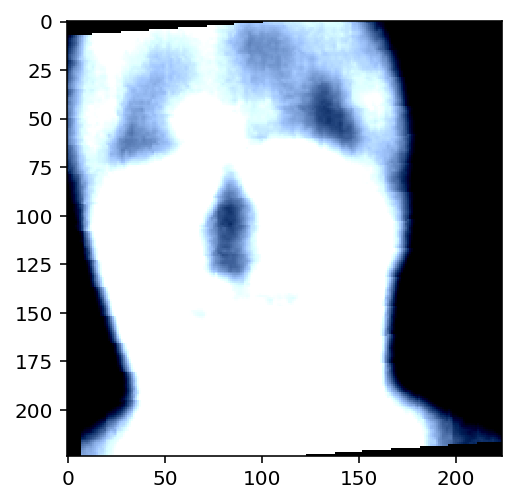

In [105]:
# test of data loader

images, labels = next(iter(train_loader))
images = images.numpy()

print("Shape:", images[0].shape, "Batch size:", len(images))
plt.imshow(np.transpose(images[0], (1,2,0)))
print(labels[0])

In [46]:
model = models.inception_v3(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/nikhil/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100.0%


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t